### Scope for improvements

* Write function to clean the names of the downloaded raw pics

In [111]:
# imports

import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import pywt

In [112]:
img = cv2.imread('data/raw/Cristiano_Ronaldo/0_Cristiano-Ronaldo-and-Manchester-United-are-in-hot-water-after-a-disappointing-weekend.jpg')

In [113]:
img.shape

(409, 615, 3)

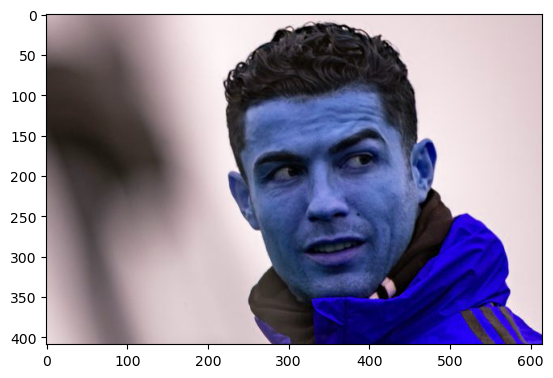

In [114]:
plt.imshow(img)

In [115]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(409, 615)

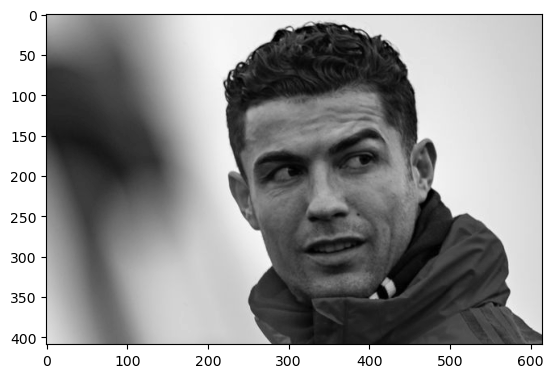

In [116]:
plt.imshow(gray, cmap = 'gray')

In [117]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

# the haar cascade detects faces on the grayscale version of the photo
faces = face_cascade.detectMultiScale(gray)

In [118]:
type(faces)

numpy.ndarray

In [119]:
def get_cropped_image_roi(path):
    """
    Function to detect a face with atleast 2 eyes in 
    the region of interest, roi (face). If yes, then return
    the cropped region of interest.
    
    Parameters:
    -----
    path: <str> path of the image
    
    Returns:
    -----
    Image: <ndarray> Roi image as ndarray 
    
    """
    # load image and convert to grayscale 
    try:
        img = cv2.imread(path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print(path)
    
    # declare the cascade models
    face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

    # detect the face coordinates from gray image
    faces = face_cascade.detectMultiScale(gray)
    
    if faces is None:
        return None

    for (y, x, w, h) in faces:
        # mark face zone with rectangle 
        face_img = cv2.rectangle(img, (y,x), (y+w, x+h), (255, 0, 0), 2)
        face_gray = cv2.rectangle(gray, (y,x), (y+w, x+h), (255, 0, 0), 2)
        # plt.imshow(face_img)

        # crop to rectangular zone
        roi_color = face_img[x:x+h, y:y+w]
        roi_gray = face_gray[x:x+h, y:y+w]

        # plt.imshow(roi_color)
        # plt.imshow(roi_gray)

        # detect eyes in roi grayscale image
        eyes_gray = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes_gray) >= 2:
            return roi_color
        else:
            return None


## Creating folders for processed data

In [120]:
import os

path_processed = 'data/processed/'
path_raw ='data/raw/'



In [121]:
# Creating folders for processed dat
img_dirname = [] # initialize list of celebrity folder names
for folder in os.scandir(path_raw):
    if folder.is_dir():
        img_dirname.append(folder.name)
        

In [122]:
img_dirname

['Cristiano_Ronaldo',
 'Karim_Benzema',
 'Lionel_Messi',
 'Luca_Modric',
 'Robert_Lewandowski']

In [123]:
import shutil

if not os.path.exists(path_processed):
    os.mkdir(path_processed)

In [124]:
for folder in img_dirname:
    if not os.path.exists(path_processed+folder):
        os.mkdir(path_processed+folder)

## Processing and storing the data

In [125]:
celebrity_images_dict = dict()
for folder in img_dirname:
    path = path_raw+folder
    
    celebrity_images_dict[folder] = []

    for i,file in enumerate(os.scandir(path)):
        processed_img = get_cropped_image_roi(file.path)
        if processed_img is None:
            continue
        processed_image_name = folder+"_"+str(i)+".png"
        try:
            cv2.imwrite(path_processed+folder+"/"+processed_image_name, processed_img)
        except:
            print(folder,i)
        
        celebrity_images_dict[folder].append(path_processed+folder+"/"+processed_image_name)

## Reviewed the processed data manually and removed a few dubious images

### Wavelet transformation

In [126]:
# Wavelet transformation from Codebasics

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

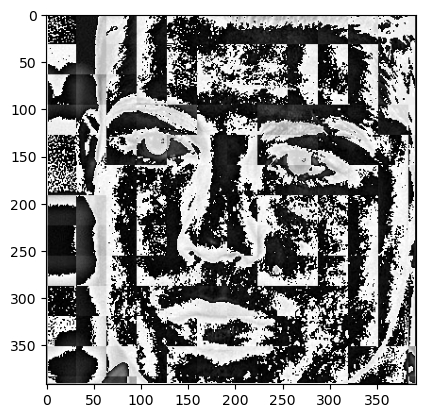

In [127]:
image = cv2.imread('data/processed/Cristiano_Ronaldo/Cristiano_Ronaldo_0.png', cv2.COLOR_RGB2GRAY)
plt.imshow(image)
im_har = w2d(image,'db1',5)
plt.imshow(im_har, cmap='gray')

## Iterate over all the processed images and generate the wavelet transformed pics

In [128]:
# checking the shape of images before and after the wavelet transform

In [129]:
image.shape

(392, 392, 3)

In [130]:
im_har.shape

(392, 392)

In [131]:
celeb_code = dict()

for i,key in enumerate(celebrity_images_dict.keys()):
    celeb_code[key] = i
    
print(celeb_code)


{'Cristiano_Ronaldo': 0, 'Karim_Benzema': 1, 'Lionel_Messi': 2, 'Luca_Modric': 3, 'Robert_Lewandowski': 4}


In [132]:
scale_size = 64
X = []
y = []

for name, img_path in celebrity_images_dict.items():
        for img in img_path:
            img_read = cv2.imread(img, cv2.COLOR_BGR2RGB)
            # scale the image
            scaled_img_raw = cv2.resize(img_read, (scale_size, scale_size))
            
            # wavelet transform
            im_har = w2d(img_read,'db1',5)
            scaled_img_har = cv2.resize(im_har, (scale_size, scale_size))
            
            # Create a combined numpy vector of the raw and har image as feature
            stacked_image = np.vstack((
                scaled_img_raw.reshape(scale_size*scale_size*3, 1),
                scaled_img_har.reshape(scale_size*scale_size, 1)
            ))
            
            X.append(stacked_image)
            y.append(celeb_code[name])
            
            
    

In [134]:
len(X)

503

In [135]:
len(X[0])

16384

In [136]:
X = np.array(X)

In [137]:
X = X.reshape(len(X), scale_size*scale_size*3 + scale_size*scale_size).astype(float)


In [138]:
X[0]

array([110.,  79.,  63., ..., 253.,  32.,  43.])

## Model Training 

### SVM

In [139]:
# imports

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split


In [140]:
# Splitinng the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [141]:
# Scaling the train data through pipeline

pipe = make_pipeline(
    StandardScaler(),
    SVC()
)
    
    

In [143]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [144]:
pipe.score(X_test, y_test)

0.7483443708609272

### Optimizing the model

#### Grid Search

In [145]:
param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
             'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'svc__kernel': ['linear', 'rbf', 'sigmoid'],
             'svc__class_weight':['balanced']}

In [146]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [147]:
grid = GridSearchCV(pipe, param_grid, verbose = 3, n_jobs = -1)

In [148]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 100, 1000],
                         'svc__class_weight': ['balanced'],
                         'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svc__kernel': ['linear', 'rbf', 'sigmoid']},
             verbose=3)

In [149]:
grid.score(X_test, y_test)

0.7947019867549668

### Trying multiple models for classification

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)

In [194]:
# models

models = {'logisticregression': LogisticRegression(random_state = 123, n_jobs = -1),
          'svc': SVC(random_state = 123),
          'randomforestclassifier': RandomForestClassifier(random_state = 123, n_jobs=-1)
                     }

In [198]:
param_grid = {
    'svc': {'svc__C': [0.1, 1, 10, 100],
            'svc__gamma': [1, 0.1, 0.01, 0.001],
            'svc__kernel': ['linear', 'rbf'],
            'svc__class_weight':['balanced']},
    'logisticregression': {'logisticregression__C': [0.1, 1, 10, 100],
                           'logisticregression__class_weight':['balanced'],
                          },
    'randomforestclassifier':{'randomforestclassifier__criterion': ["gini", "log_loss"],
                              'randomforestclassifier__max_depth':[2,3,4]}
}

In [202]:
scores = []
best_estimator = dict()
for model in models:
    pipe_model = make_pipeline(StandardScaler(), models[model])
    clf = GridSearchCV(pipe_model, param_grid[model], verbose = 3, n_jobs = -1)
    print(param_grid[model])
    clf.fit(X_train, y_train)
    scores.append({'model': model,
                  'best_score': clf.best_score_,
                  'best_parameters': clf.best_params_})
    best_estimator[model] = clf.best_estimator_

{'logisticregression__C': [0.1, 1, 10, 100], 'logisticregression__class_weight': ['balanced']}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'svc__C': [0.1, 1, 10, 100], 'svc__gamma': [1, 0.1, 0.01, 0.001], 'svc__kernel': ['linear', 'rbf'], 'svc__class_weight': ['balanced']}
Fitting 5 folds for each of 32 candidates, totalling 160 fits
{'randomforestclassifier__criterion': ['gini', 'log_loss'], 'randomforestclassifier__max_depth': [2, 3, 4]}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [203]:
scores

[{'model': 'logisticregression',
  'best_score': 0.8236619718309859,
  'best_parameters': {'logisticregression__C': 100,
   'logisticregression__class_weight': 'balanced'}},
 {'model': 'svc',
  'best_score': 0.7954124748490947,
  'best_parameters': {'svc__C': 0.1,
   'svc__class_weight': 'balanced',
   'svc__gamma': 1,
   'svc__kernel': 'linear'}},
 {'model': 'randomforestclassifier',
  'best_score': 0.6390744466800805,
  'best_parameters': {'randomforestclassifier__criterion': 'log_loss',
   'randomforestclassifier__max_depth': 4}}]

In [205]:
import pandas as pd
pd.DataFrame(scores)

,model,best_score,best_parameters
0,logisticregression,0.823662,"{'logisticregression__C': 100, 'logisticregres..."
1,svc,0.795412,"{'svc__C': 0.1, 'svc__class_weight': 'balanced..."
2,randomforestclassifier,0.639074,{'randomforestclassifier__criterion': 'log_los...


Based on the Cross Validation scores Logistic Regression gives the best score

#### Testing model performance on Test data

In [210]:
best_estimator['logisticregression'].score(X_test, y_test)

0.8079470198675497

#### Confustion matrix

Text(50.722222222222214, 0.5, 'Predicted Values')

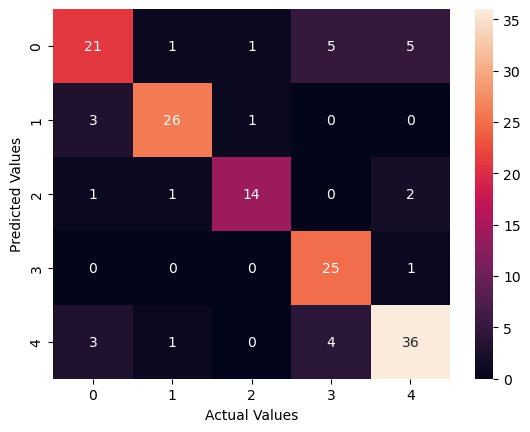

In [212]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_estimator['logisticregression'].predict(X_test))

sns.heatmap(cm, annot = True)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

### Eporting models

In [215]:
# Exporting the model to a file
import joblib

joblib.dump(best_estimator['logisticregression'], 'celebrity_clf_logreg.pkl')



['celebrity_clf_logreg.pkl']

In [218]:
# Exporting the celebrity dictionary 
import json
with open("celeb_code", "w") as f:
    f.write(json.dumps(celeb_code))